In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn import preprocessing
from adjustText import adjust_text

expr = pd.read_csv("Processed_Data/normalized_expression.csv", index_col=0)
metadata = pd.read_csv("Processed_Data/metadata.csv")


<class 'pandas.core.frame.DataFrame'>
Index: 23281 entries, 1 to 24511
Columns: 172 entries, ID to GSM1180919_Srujana-HuGene33_9.CEL.gz
dtypes: float64(170), int64(1), object(1)
memory usage: 30.7+ MB


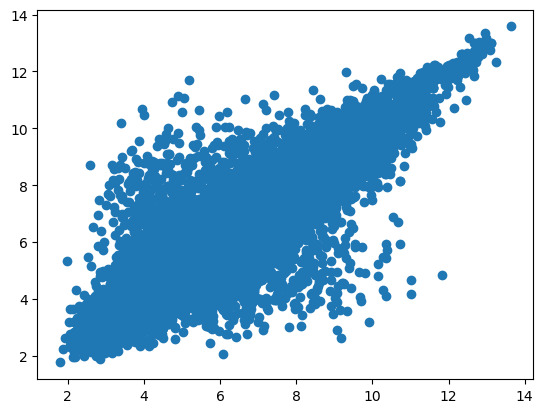

In [3]:
test = expr.iloc[:, 2:4]
plt.figure(1)
plt.plot(expr.iloc[:,55], expr.iloc[:, 100], 'o')
expr.info()


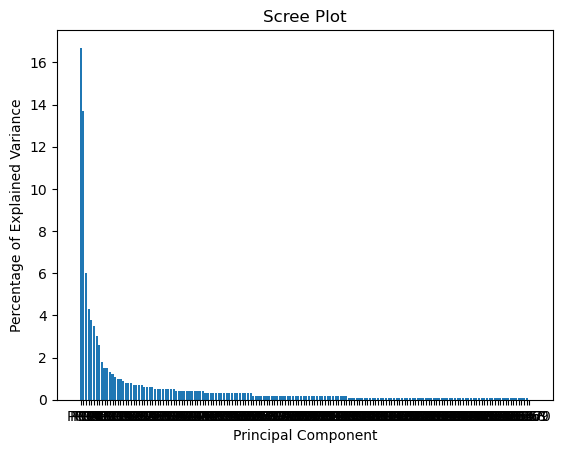

In [ ]:
#print(expr.head())
#print(expr.shape)

# object_column_names = expr.select_dtypes(include='object').columns
# print(object_column_names)
# gene_symbols = expr['gene_symbol']
# expr_numeric = expr.drop(columns='gene_symbol')
#expr_numeric = expr.drop(columns='ID')
#print(expr_numeric)
#(measurement - mean)^2/(numbers of measurement)
expr_numeric = expr.select_dtypes(include=np.number)
expr_numeric = expr_numeric.drop(columns=['ID'])
scaled_data = preprocessing.scale(expr_numeric.T)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
#print(expr_numeric)
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1 )]

plt.bar(x = range(1, len(per_var) + 1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
#plt.savefig("PCA's Scree Plot", dpi = 300)
plt.show()

<Figure size 640x480 with 0 Axes>

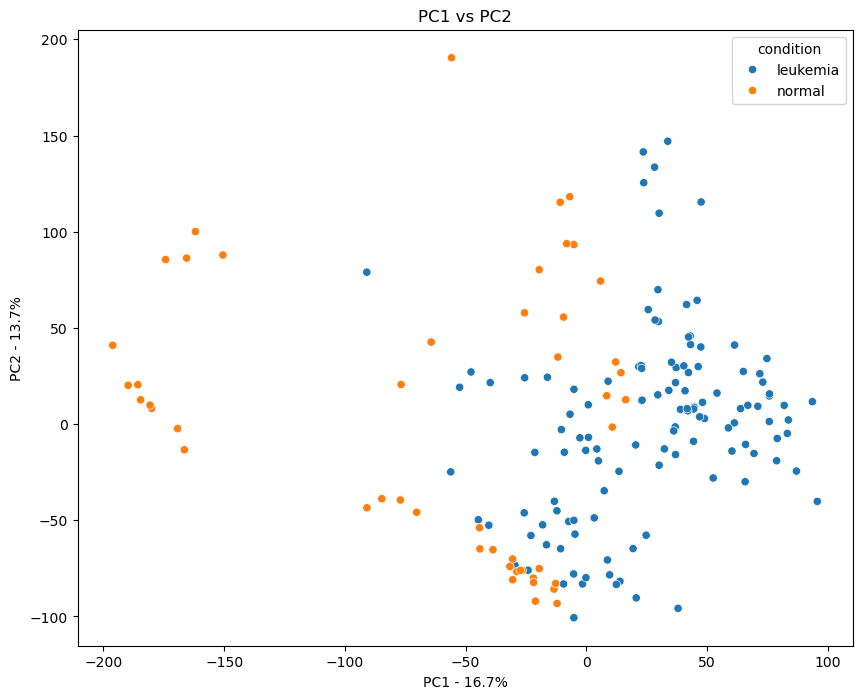

<Figure size 640x480 with 0 Axes>

In [11]:
pca_df = pd.DataFrame(pca_data, index = None ,columns = labels)
pca_df = pca_df.join(metadata)
plt.figure(1)
plt.figure(figsize=(10, 8))
sb.scatterplot(data = pca_df,
               x = 'PC1',
               y = "PC2",
               hue = 'condition')
plt.title('PC1 vs PC2')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

# for sample in pca_df.index:
#      plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
plt.show()
fig1 = plt.gcf()


<Figure size 640x480 with 0 Axes>

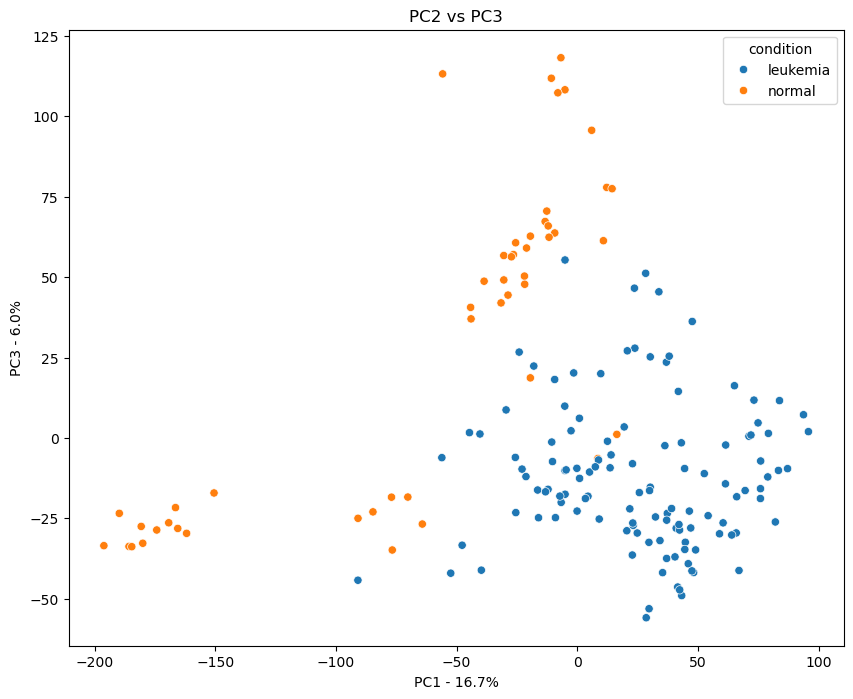

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(2)
plt.figure(figsize=(10, 8))
sb.scatterplot(data = pca_df,
               x = 'PC1',
               y = "PC3",
               hue = 'condition')
plt.title('PC2 vs PC3')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC3 - {0}%'.format(per_var[2]))

# for sample in pca_df.index:
#     plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
plt.show()
fig2 = plt.gcf()

<Figure size 640x480 with 0 Axes>

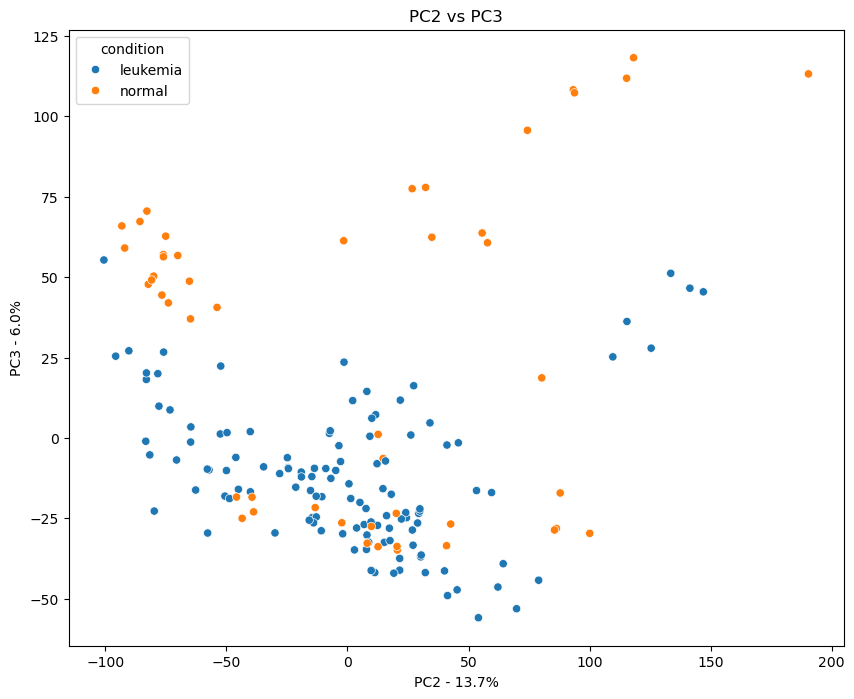

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(3)
plt.figure(figsize=(10, 8))
sb.scatterplot(data = pca_df,
               x = 'PC2',
               y = "PC3",
               hue = 'condition')
plt.title('PC2 vs PC3')
plt.xlabel('PC2 - {0}%'.format(per_var[1]))
plt.ylabel('PC3 - {0}%'.format(per_var[2]))

# for sample in pca_df.index:
#     plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
plt.show()
fig3 = plt.gcf()

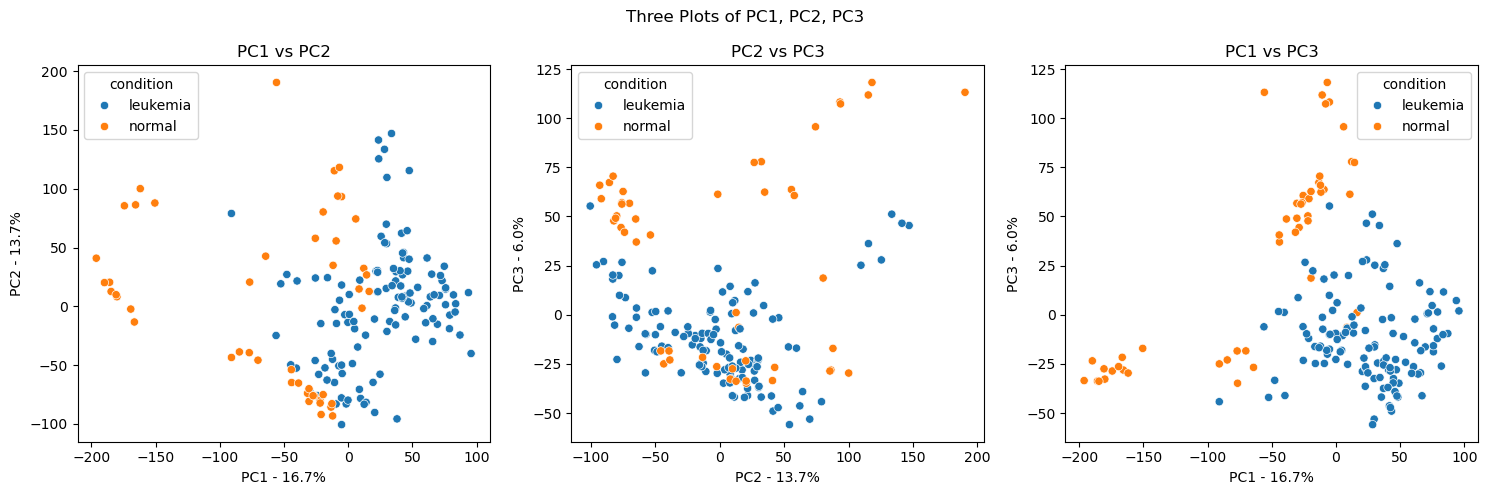

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_configs = [
    ('PC1', 'PC2', 0, 1),
    ('PC2', 'PC3', 1, 2),
    ('PC1', 'PC3', 0, 2)
]

for i, (x_pc, y_pc, x_idx, y_idx) in enumerate(plot_configs):
    sb.scatterplot(data=pca_df, 
                   x=x_pc, 
                   y=y_pc, 
                   hue='condition', 
                   ax=axs[i])
    
    axs[i].set_title(f"{x_pc} vs {y_pc}")
    axs[i].set_xlabel(f'{x_pc} - {per_var[x_idx]}%')
    axs[i].set_ylabel(f'{y_pc} - {per_var[y_idx]}%')

fig.suptitle("Three Plots of PC1, PC2, PC3")
plt.tight_layout()
#plt.savefig("Three Plots of PC1, PC2, PC3", dpi = 300, transparent = False, pad_inches = 0.2)
plt.show()


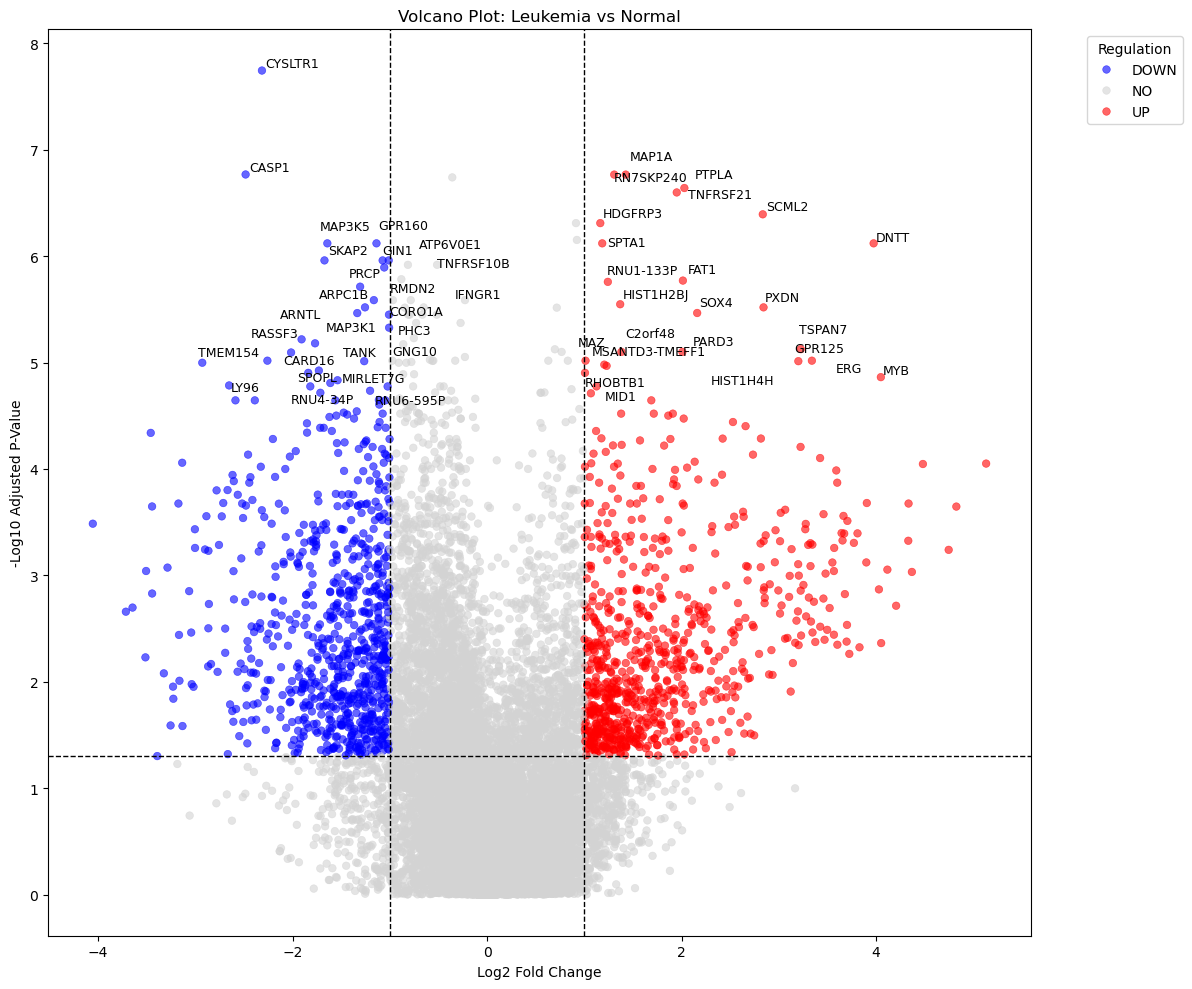

In [ ]:
expr_stats = pd.read_csv("Processed_Data/expr_stats.csv")
expr_stats['-log10(padj)'] = -np.log10(expr_stats['adj_p_values'])

fc_threshold = 1
p_threshold = 0.05

conditions = [
    (expr_stats['log2_foldchange'] > fc_threshold ) & (expr_stats['adj_p_values'] < p_threshold),
    (expr_stats['log2_foldchange'] < -fc_threshold ) & (expr_stats['adj_p_values'] < p_threshold)
]

#UP = Gene is more expressed in leukemia, #DOWN = Gene is more expressed in normal
choices = ["UP", "DOWN"] 

expr_stats['expression'] = np.select(conditions, choices, default = "NO")

plt.figure(figsize=(12,10))
colors = {'UP': 'red', 'DOWN': 'blue', 'NO': 'lightgrey'}
sb.scatterplot(data = expr_stats,
                x = 'log2_foldchange',
                y = '-log10(padj)',
                hue = 'expression',
                palette = colors,
                alpha = 0.6,         #Transparency
                edgecolor = None,    #Remove outlines
                s = 30)   
# Add threshold lines
plt.axvline(x=fc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-fc_threshold, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-np.log10(p_threshold), color='black', linestyle='--', linewidth=1)

plt.title('Volcano Plot: Leukemia vs Normal')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.legend(title='Regulation', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside to save space

texts = [] 
sig_genes_df = expr_stats[(expr_stats['expression'] == 'UP') | (expr_stats['expression'] == 'DOWN')]
sig_genes_df = sig_genes_df.sort_values(by='adj_p_values', ascending=True)

num_genes = 50
genes_to_label = sig_genes_df.head(num_genes)

# Loop through the selected genes and create text objects
for i in range(genes_to_label.shape[0]):
    texts.append(plt.text(x=genes_to_label.log2_foldchange.iloc[i], 
                          y=genes_to_label['-log10(padj)'].iloc[i], 
                          s=genes_to_label.gene_symbol.iloc[i],
                          fontsize=9))

# Call adjust_text to prevent overlaps
adjust_text(texts, 
            #arrowprops=dict(arrowstyle='-', color='darkgrey', lw=0.5), 
            expand_points=(2, 2)) 

plt.tight_layout()
#plt.savefig("Volcano Plot - Leukemia vs Normal", dpi = 300, transparent = False, pad_inches = 0.2)
plt.show()

c:\skitbio\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\skitbio\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


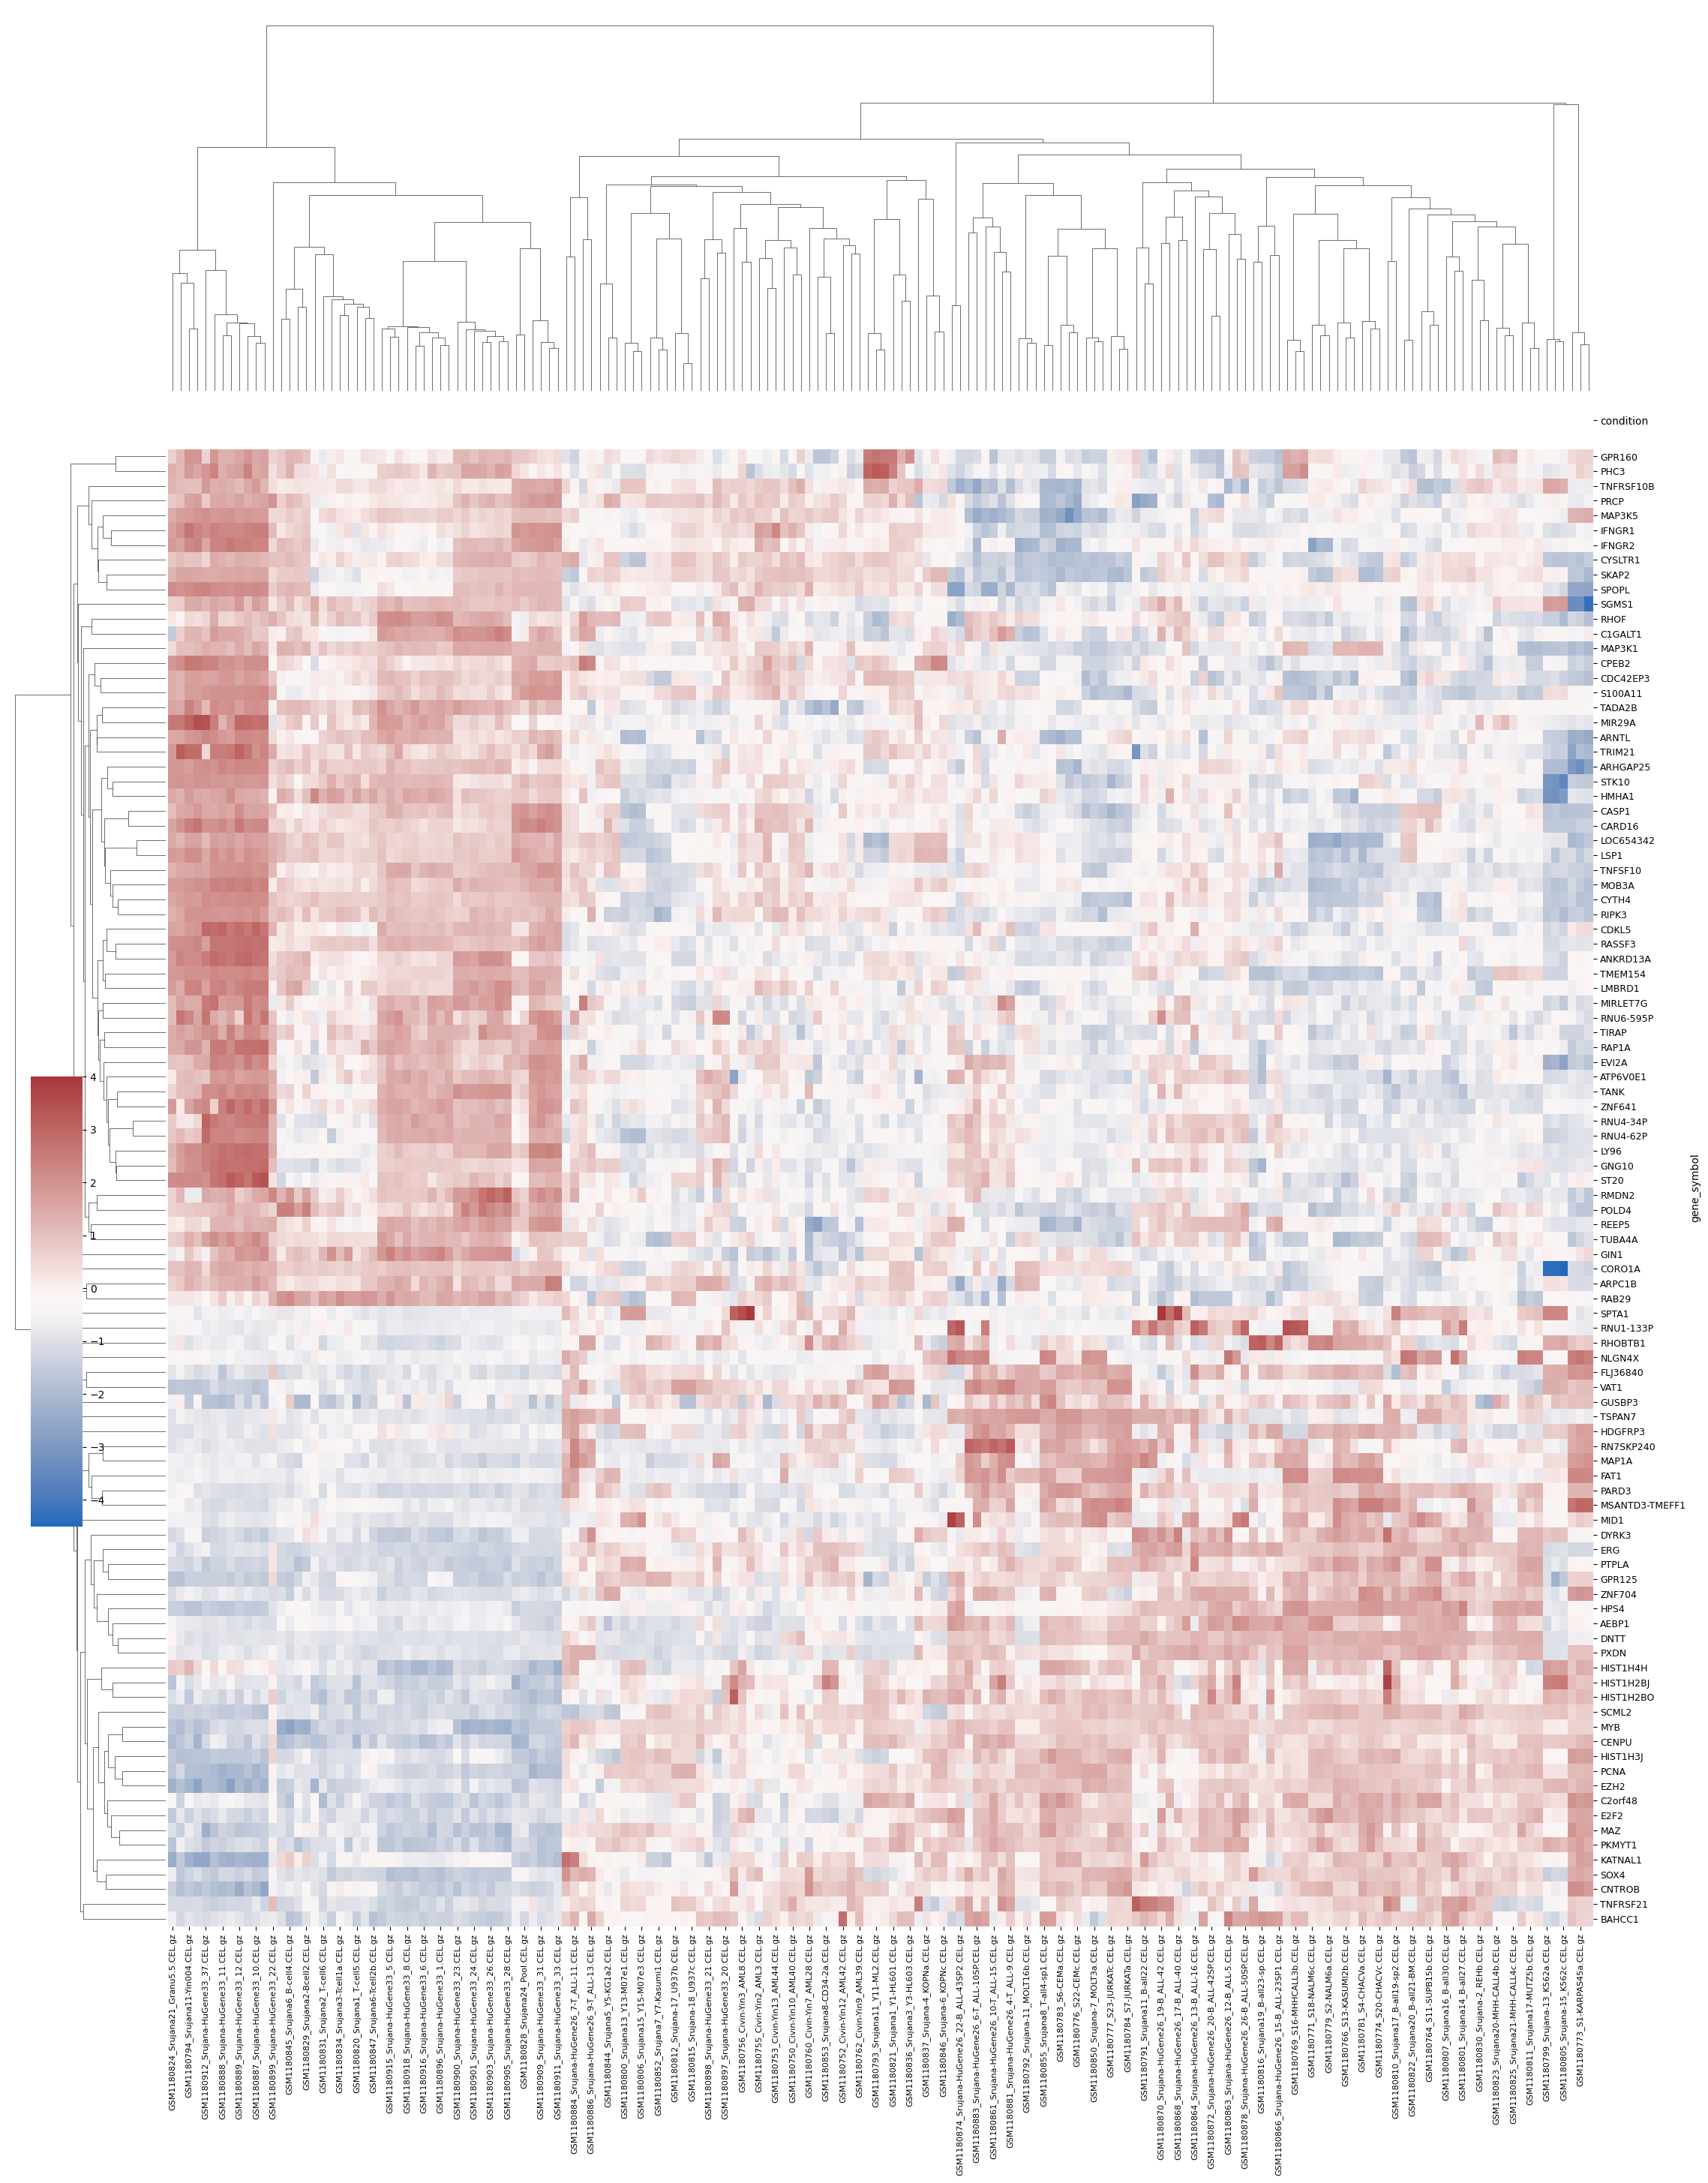

In [10]:
heatmap_data = sig_genes_df.head(100).set_index('gene_symbol')
conditions_colors = metadata.condition.map({
    'normal': 'red', 
    'leukemia': 'blue'
})

g = sb.clustermap(heatmap_data.filter(like='GSM'),
                  z_score= 0,
                  cmap = "vlag",
                  col_colors= conditions_colors,
                  figsize=(23,30),
                  dendrogram_ratio=(.1, .2),
                  cbar_pos=(.02, .32, .03, .2))
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=8) # Sample names
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=9) # Gene names
# Save
#plt.savefig("Heatmap - Top 100 Significant Genes", dpi=300)
plt.show()

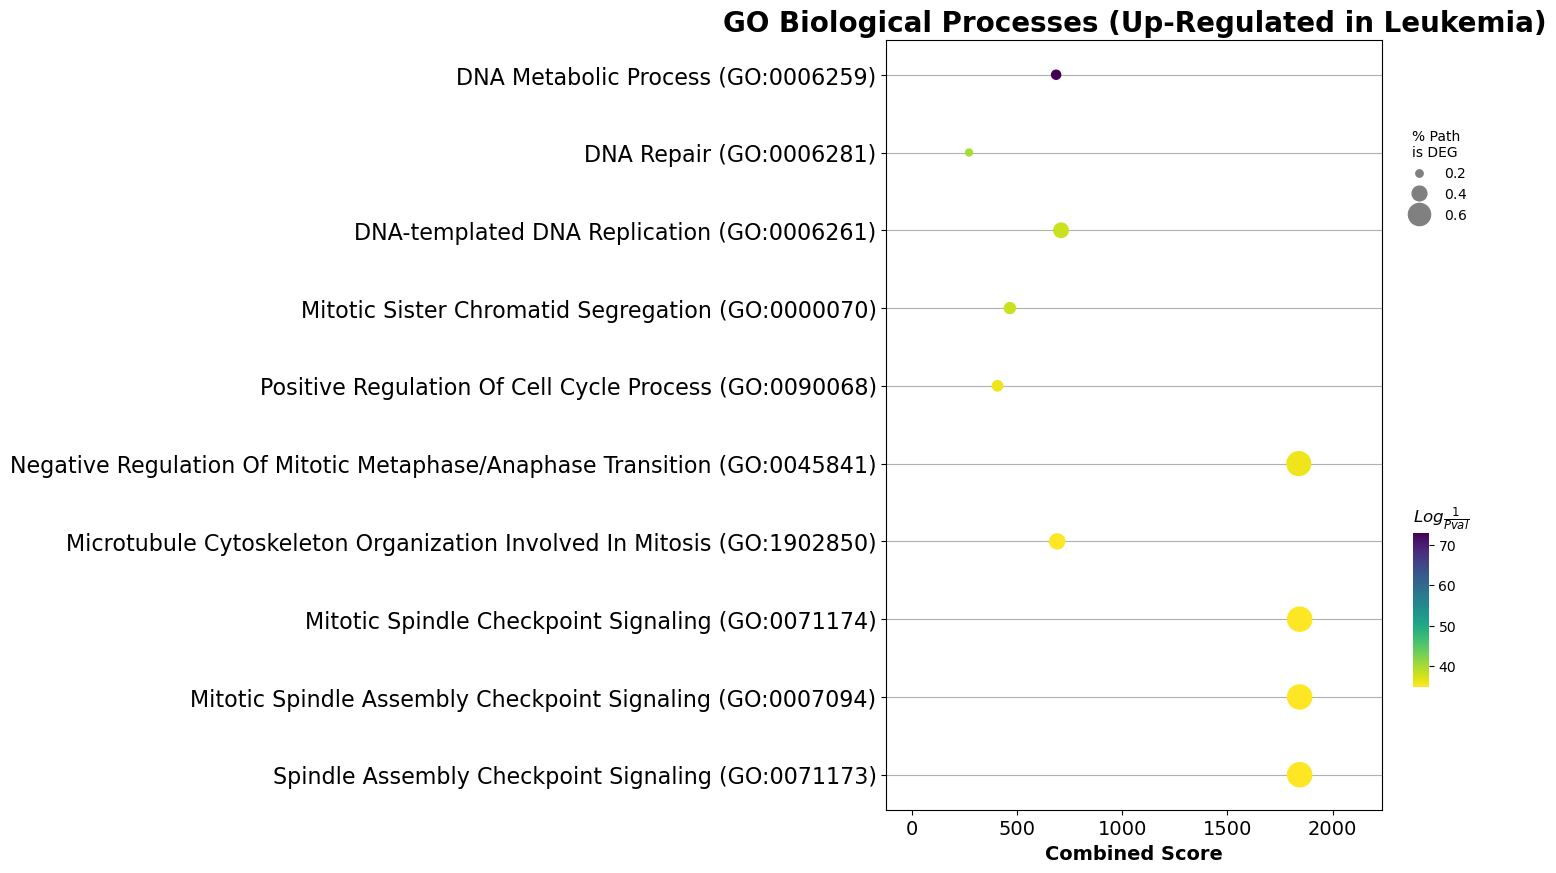

In [54]:
import gseapy as gp
from gseapy.plot import dotplot
up_genes = expr_stats[(expr_stats['expression'] == "UP")].gene_symbol.tolist()
down_genes = expr_stats[(expr_stats['expression'] == "DOWN")].gene_symbol.tolist()

enr_go_up = gp.enrichr(gene_list = up_genes,
                    gene_sets = 'GO_Biological_Process_2023',
                    organism = "human",
                    background = expr_stats.gene_symbol,
                    outdir = None)

ax = dotplot(enr_go_up.res2d,
             title = "GO Biological Processes (Up-Regulated in Leukemia)",
             cmap='viridis_r',
             top_term = 10,
             figsize = (8,10))
plt.savefig("GO Biological Processes (Up-Regulated in Leukemia)", dpi = 300, bbox_inches='tight')
plt.show()

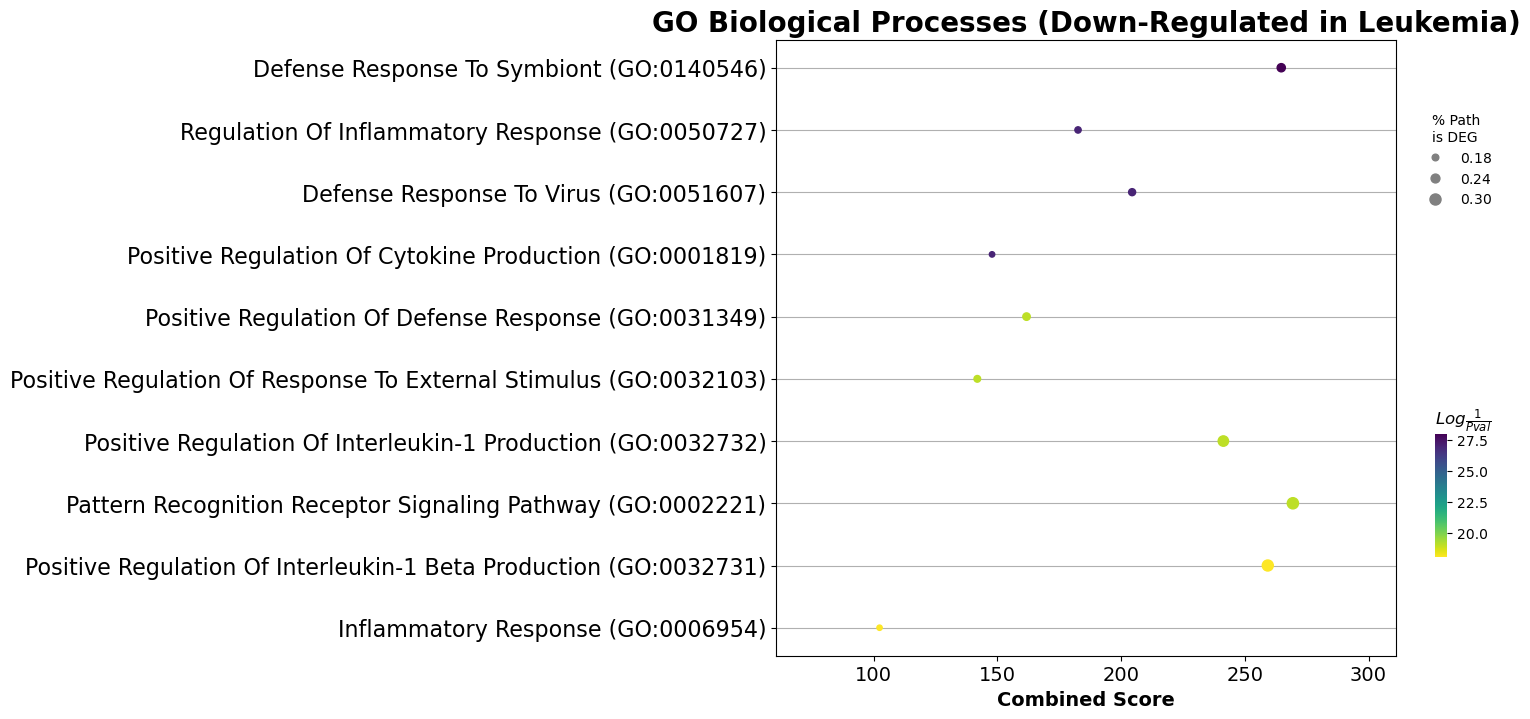

In [53]:

enr_go_down = gp.enrichr(gene_list = down_genes,
                      gene_sets = 'GO_Biological_Process_2023',
                      organism = "human",
                      background =  expr,
                      outdir = None)
ax = dotplot(enr_go_down.res2d,
             title = "GO Biological Processes (Down-Regulated in Leukemia)",
             cmap='viridis_r', 
             top_term = 10,
             figsize = (10,8))
plt.savefig("GO Biological Processes (Down-Regulated in Leukemia)", dpi = 300, bbox_inches='tight')
plt.show()

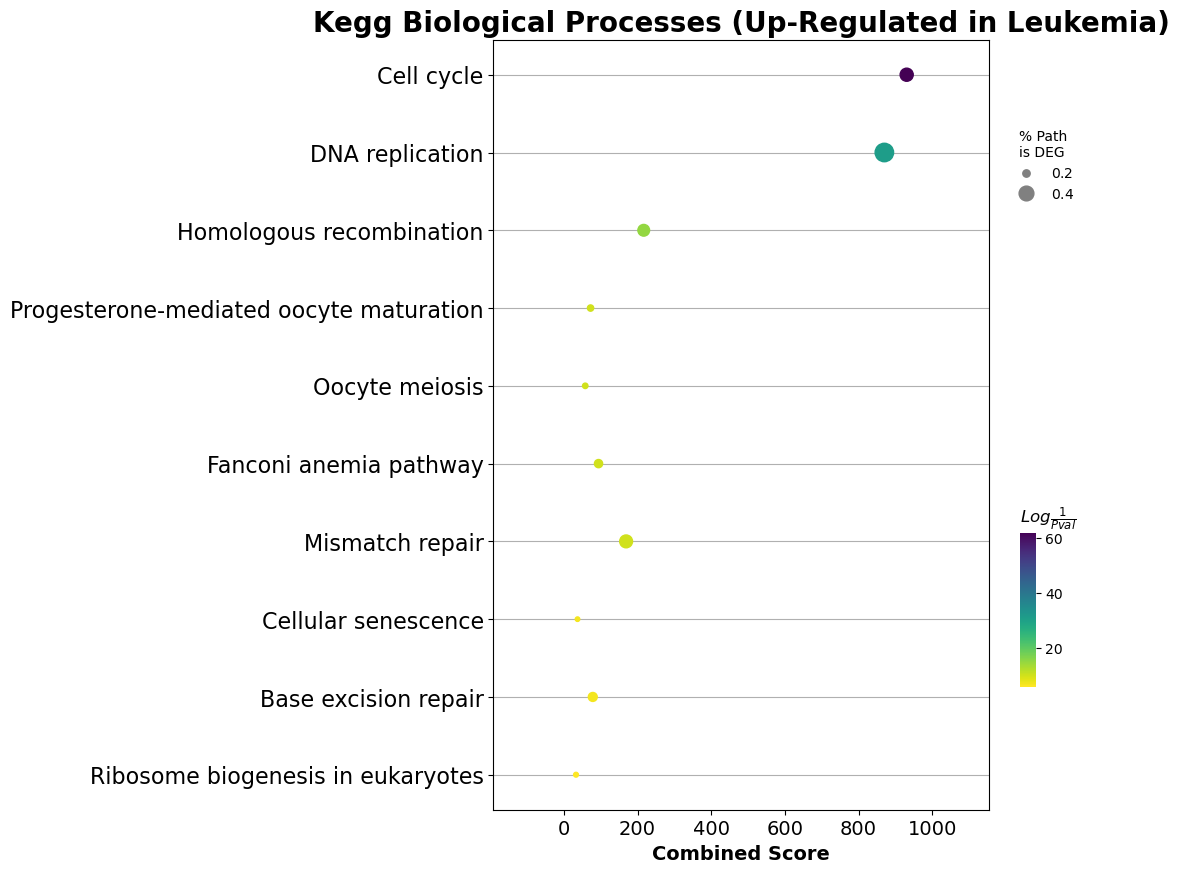

In [52]:
enr_kegg_up = gp.enrichr(gene_list = up_genes,
                    gene_sets = 'KEGG_2021_Human',
                    organism = "human",
                    background = expr_stats.gene_symbol,
                    outdir = None)

ax = dotplot(enr_kegg_up.res2d,
             title = "Kegg Biological Processes (Up-Regulated in Leukemia)",
             cmap='viridis_r',
             top_term = 10,
             figsize = (8,10))
plt.savefig("Kegg Biological Processes (Up-Regulated in Leukemia)", dpi = 300, bbox_inches='tight')
plt.show()

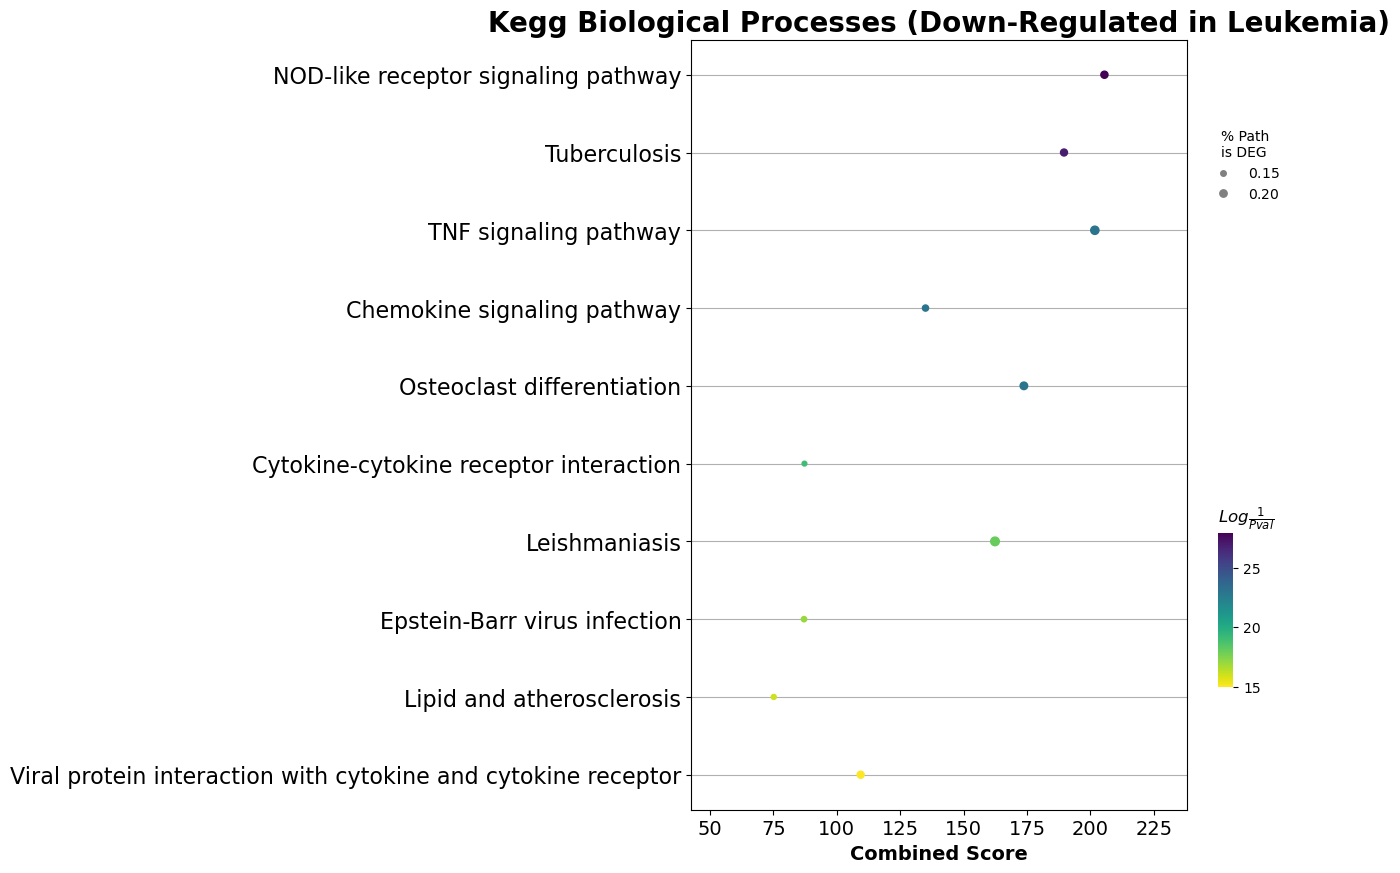

In [51]:
enr_kegg_down = gp.enrichr(gene_list = down_genes,
                    gene_sets = 'KEGG_2021_Human',
                    organism = "human",
                    background = expr_stats.gene_symbol,
                    outdir = None)

ax = dotplot(enr_kegg_down.res2d,
             title = "Kegg Biological Processes (Down-Regulated in Leukemia)",
             cmap='viridis_r',
             top_term = 10,
             figsize = (8,10))
plt.savefig("Kegg Biological Processes (Down-Regulated in Leukemia)", dpi = 300, bbox_inches='tight')
plt.show()

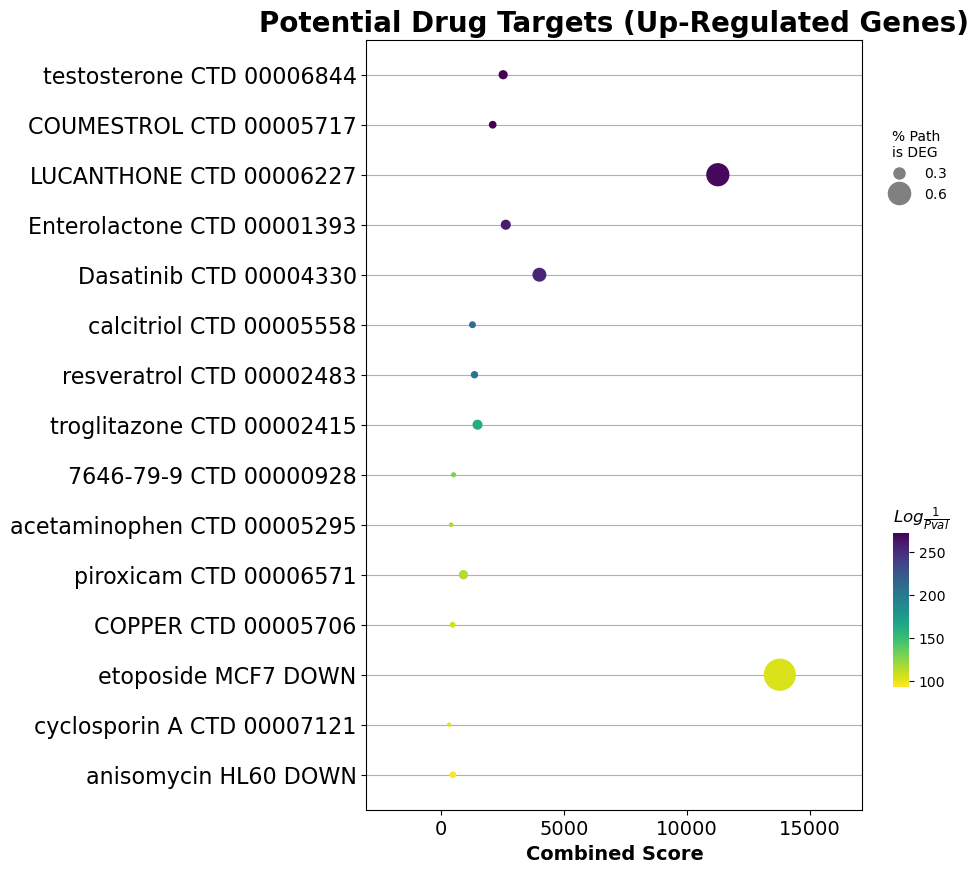

In [44]:
enr_drug = gp.enrichr(gene_list = up_genes,
                    gene_sets = 'DSigDB',
                    organism = "human",
                    background = expr_stats.gene_symbol,
                    outdir = None)

ax = dotplot(enr_drug.res2d,
             title = "Potential Drug Targets (Up-Regulated Genes)",
             cmap='viridis_r',
             top_term = 15,
             figsize = (8,10))
plt.savefig("Drug_Target_Analysis.png", dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'ID'